In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))
test_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset((train_set, test_set)),
    batch_size=64,
    shuffle=True)

In [4]:
x = np.array(train_set.train_data)

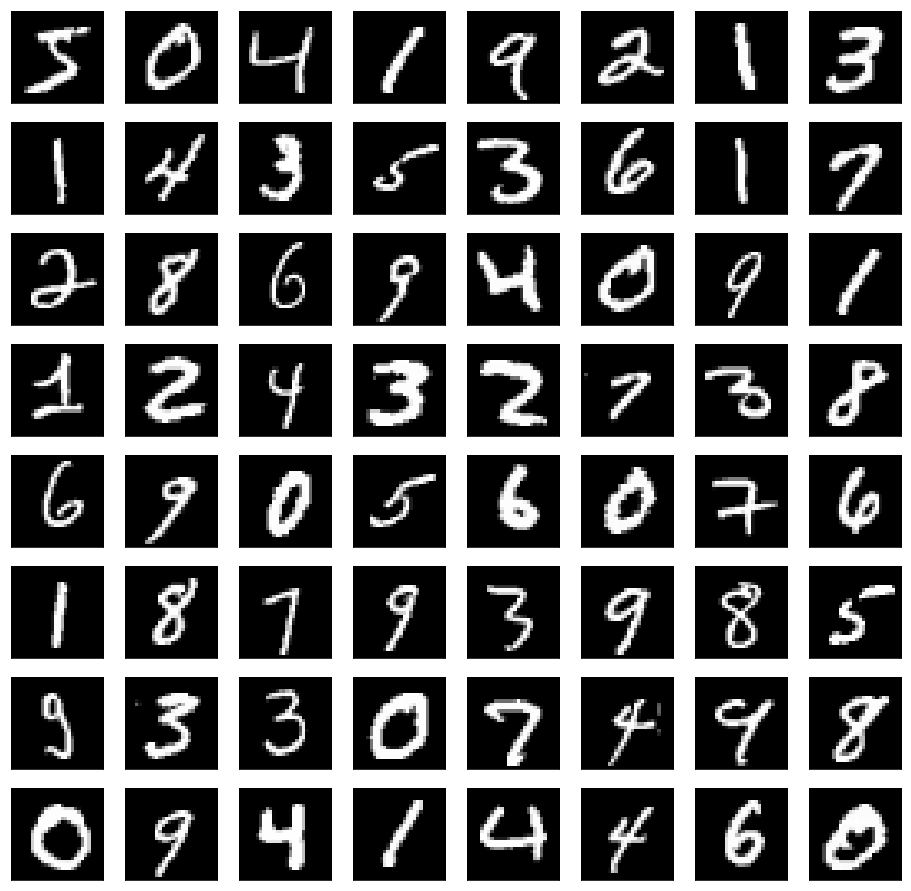

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
class GAN_:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.loss = torch.nn.functional.binary_cross_entropy

        self.g = None
        self.d = None

    def fit(self, data_loader, epochs):
        self.g.to(self.device)
        self.d.to(self.device)
        history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
        for epoch in range(1, epochs + 1):
            self.g.train()
            self.d.train()
            start_time = time.time()
            g_loss, d_loss, d_acc = 0, 0, 0
            for real_imgs, _ in data_loader:
                real = torch.Tensor(real_imgs.size(0), 1).fill_(0.9).to(self.device)
                fake = torch.Tensor(real_imgs.size(0), 1).fill_(0.0).to(self.device)
                real_imgs = real_imgs.to(self.device)
                fake_imgs = self.g(torch.Tensor(
                    np.random.normal(0, 1, (real_imgs.size(0), 100))).to(self.device))
                # Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Train generator
                self.g.optimizer.zero_grad()
                g_loss_ = self.loss(self.d(fake_imgs), real)
                g_loss_.backward()
                self.g.optimizer.step()
                # Calculate metrics for batch
                g_loss += float(g_loss_) * len(real_imgs)
                d_loss += float(d_loss_) * len(real_imgs)
                d_acc += int((real_out >= 0.5).sum()) + int((fake_out < 0.5).sum())
            # Calculate metrics for epoch
            g_loss /= len(data_loader.dataset)
            d_loss /= len(data_loader.dataset)
            d_acc /= 2 * len(data_loader.dataset)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['g_loss'].append(g_loss)
            history['d_loss'].append(d_loss)
            history['d_acc'].append(d_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')

            if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
                fake_imgs = self.g(torch.Tensor(
                    np.random.normal(0, 1, (24, 100))).to(self.device)).detach().cpu()
                plt.figure(figsize=(16, 6))
                for i in range(24):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(fake_imgs[i], cmap=plt.cm.gray)
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

        return history

In [8]:
class GAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(100, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(256),
                    torch.nn.Linear(256, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(512),
                    torch.nn.Linear(512, 1024),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(1024),
                    torch.nn.Linear(1024, 784),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(784, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(512, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(256, 1),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), -1)
                for layer in self.layers:
                    x = layer(x)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [9]:
model = GAN()

[  1/100] 14.3s - g_loss: 0.9176 - d_loss: 0.5930 - d_acc: 0.7153


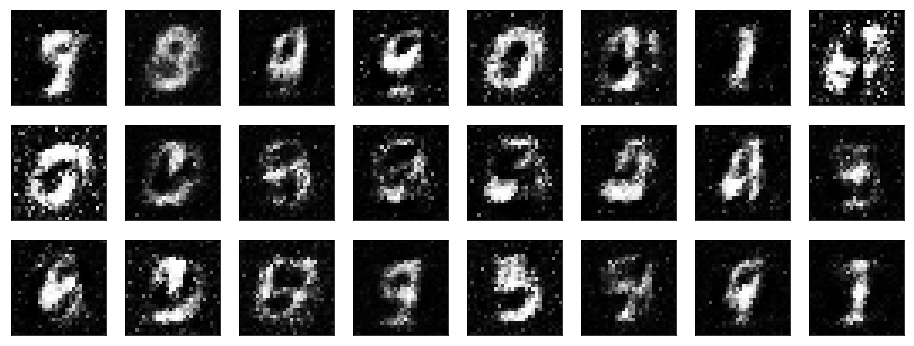

[  2/100] 13.5s - g_loss: 0.9390 - d_loss: 0.6278 - d_acc: 0.6579
[  3/100] 13.9s - g_loss: 0.9248 - d_loss: 0.6375 - d_acc: 0.6405
[  4/100] 14.0s - g_loss: 0.8658 - d_loss: 0.6609 - d_acc: 0.5983
[  5/100] 13.9s - g_loss: 0.8387 - d_loss: 0.6710 - d_acc: 0.5747
[  6/100] 13.9s - g_loss: 0.8281 - d_loss: 0.6751 - d_acc: 0.5636
[  7/100] 13.9s - g_loss: 0.8238 - d_loss: 0.6769 - d_acc: 0.5569
[  8/100] 14.0s - g_loss: 0.8238 - d_loss: 0.6777 - d_acc: 0.5550
[  9/100] 13.8s - g_loss: 0.8168 - d_loss: 0.6799 - d_acc: 0.5485
[ 10/100] 13.9s - g_loss: 0.8141 - d_loss: 0.6807 - d_acc: 0.5433
[ 11/100] 13.9s - g_loss: 0.8119 - d_loss: 0.6817 - d_acc: 0.5411
[ 12/100] 14.0s - g_loss: 0.8106 - d_loss: 0.6815 - d_acc: 0.5405
[ 13/100] 14.2s - g_loss: 0.8095 - d_loss: 0.6817 - d_acc: 0.5387
[ 14/100] 13.9s - g_loss: 0.8086 - d_loss: 0.6816 - d_acc: 0.5382
[ 15/100] 13.9s - g_loss: 0.8087 - d_loss: 0.6810 - d_acc: 0.5405
[ 16/100] 13.9s - g_loss: 0.8064 - d_loss: 0.6824 - d_acc: 0.5369
[ 17/100] 

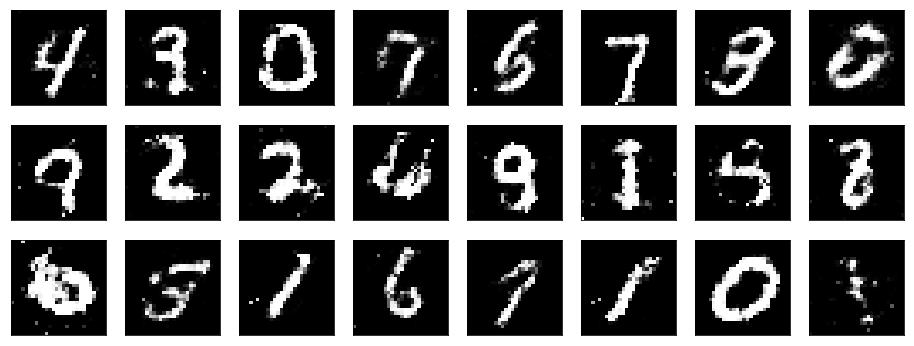

[ 21/100] 14.2s - g_loss: 0.8033 - d_loss: 0.6824 - d_acc: 0.5339
[ 22/100] 14.1s - g_loss: 0.8023 - d_loss: 0.6828 - d_acc: 0.5320
[ 23/100] 14.2s - g_loss: 0.8020 - d_loss: 0.6828 - d_acc: 0.5317
[ 24/100] 14.2s - g_loss: 0.8010 - d_loss: 0.6830 - d_acc: 0.5314
[ 25/100] 14.3s - g_loss: 0.7989 - d_loss: 0.6836 - d_acc: 0.5294
[ 26/100] 14.1s - g_loss: 0.8007 - d_loss: 0.6831 - d_acc: 0.5292
[ 27/100] 14.0s - g_loss: 0.7990 - d_loss: 0.6835 - d_acc: 0.5292
[ 28/100] 13.8s - g_loss: 0.7997 - d_loss: 0.6835 - d_acc: 0.5291
[ 29/100] 14.1s - g_loss: 0.7987 - d_loss: 0.6834 - d_acc: 0.5276
[ 30/100] 14.2s - g_loss: 0.7978 - d_loss: 0.6837 - d_acc: 0.5283
[ 31/100] 14.1s - g_loss: 0.7982 - d_loss: 0.6836 - d_acc: 0.5283
[ 32/100] 13.9s - g_loss: 0.7973 - d_loss: 0.6839 - d_acc: 0.5270
[ 33/100] 14.0s - g_loss: 0.7972 - d_loss: 0.6842 - d_acc: 0.5247
[ 34/100] 14.2s - g_loss: 0.7965 - d_loss: 0.6841 - d_acc: 0.5257
[ 35/100] 14.0s - g_loss: 0.7966 - d_loss: 0.6840 - d_acc: 0.5252
[ 36/100] 

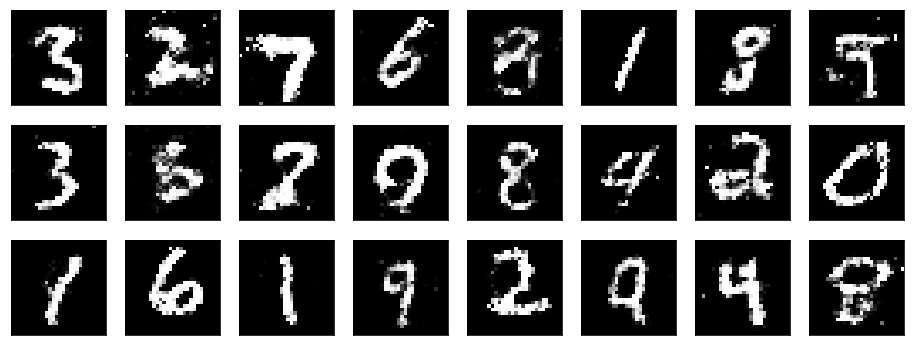

[ 41/100] 13.8s - g_loss: 0.7958 - d_loss: 0.6844 - d_acc: 0.5235
[ 42/100] 13.8s - g_loss: 0.7965 - d_loss: 0.6843 - d_acc: 0.5243
[ 43/100] 13.9s - g_loss: 0.7950 - d_loss: 0.6848 - d_acc: 0.5216
[ 44/100] 13.8s - g_loss: 0.7948 - d_loss: 0.6842 - d_acc: 0.5238
[ 45/100] 13.8s - g_loss: 0.7948 - d_loss: 0.6850 - d_acc: 0.5210
[ 46/100] 13.8s - g_loss: 0.7941 - d_loss: 0.6845 - d_acc: 0.5229
[ 47/100] 13.9s - g_loss: 0.7946 - d_loss: 0.6848 - d_acc: 0.5222
[ 48/100] 13.8s - g_loss: 0.7940 - d_loss: 0.6850 - d_acc: 0.5199
[ 49/100] 13.8s - g_loss: 0.7929 - d_loss: 0.6848 - d_acc: 0.5200
[ 50/100] 13.8s - g_loss: 0.7935 - d_loss: 0.6849 - d_acc: 0.5212
[ 51/100] 14.6s - g_loss: 0.7938 - d_loss: 0.6850 - d_acc: 0.5202
[ 52/100] 14.2s - g_loss: 0.7943 - d_loss: 0.6849 - d_acc: 0.5202
[ 53/100] 14.3s - g_loss: 0.7939 - d_loss: 0.6853 - d_acc: 0.5195
[ 54/100] 14.1s - g_loss: 0.7925 - d_loss: 0.6849 - d_acc: 0.5217
[ 55/100] 14.2s - g_loss: 0.7939 - d_loss: 0.6850 - d_acc: 0.5202
[ 56/100] 

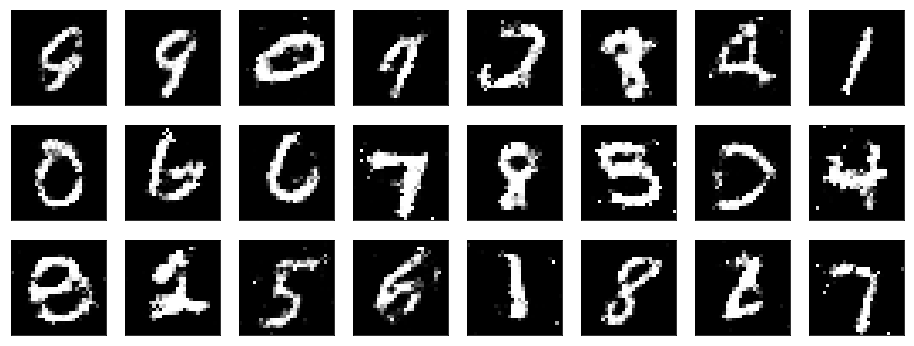

[ 61/100] 14.2s - g_loss: 0.7937 - d_loss: 0.6849 - d_acc: 0.5207
[ 62/100] 14.5s - g_loss: 0.7933 - d_loss: 0.6850 - d_acc: 0.5210
[ 63/100] 14.5s - g_loss: 0.7926 - d_loss: 0.6854 - d_acc: 0.5185
[ 64/100] 14.5s - g_loss: 0.7920 - d_loss: 0.6855 - d_acc: 0.5179
[ 65/100] 14.4s - g_loss: 0.7909 - d_loss: 0.6857 - d_acc: 0.5155
[ 66/100] 14.4s - g_loss: 0.7918 - d_loss: 0.6853 - d_acc: 0.5184
[ 67/100] 14.5s - g_loss: 0.7915 - d_loss: 0.6853 - d_acc: 0.5186
[ 68/100] 14.5s - g_loss: 0.7920 - d_loss: 0.6857 - d_acc: 0.5156
[ 69/100] 14.8s - g_loss: 0.7918 - d_loss: 0.6854 - d_acc: 0.5166
[ 70/100] 14.7s - g_loss: 0.7918 - d_loss: 0.6858 - d_acc: 0.5174
[ 71/100] 15.0s - g_loss: 0.7912 - d_loss: 0.6853 - d_acc: 0.5185
[ 72/100] 14.5s - g_loss: 0.7913 - d_loss: 0.6856 - d_acc: 0.5176
[ 73/100] 14.4s - g_loss: 0.7914 - d_loss: 0.6855 - d_acc: 0.5171
[ 74/100] 14.4s - g_loss: 0.7913 - d_loss: 0.6856 - d_acc: 0.5179
[ 75/100] 14.4s - g_loss: 0.7915 - d_loss: 0.6855 - d_acc: 0.5177
[ 76/100] 

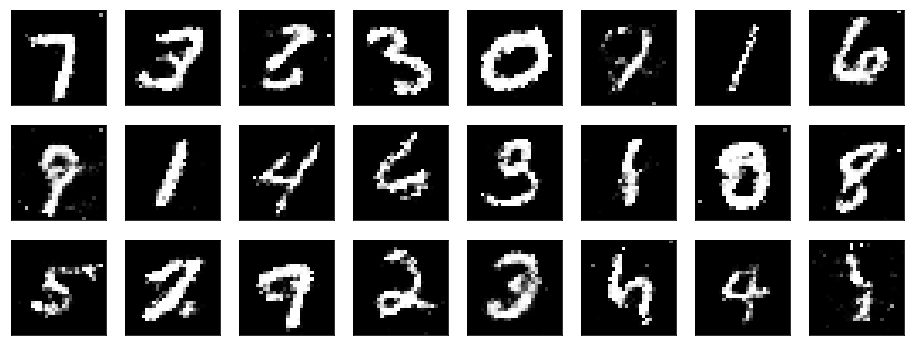

[ 81/100] 14.1s - g_loss: 0.7899 - d_loss: 0.6864 - d_acc: 0.5144
[ 82/100] 13.7s - g_loss: 0.7902 - d_loss: 0.6860 - d_acc: 0.5143
[ 83/100] 13.8s - g_loss: 0.7901 - d_loss: 0.6858 - d_acc: 0.5145
[ 84/100] 13.6s - g_loss: 0.7904 - d_loss: 0.6856 - d_acc: 0.5168
[ 85/100] 14.0s - g_loss: 0.7907 - d_loss: 0.6862 - d_acc: 0.5149
[ 86/100] 13.9s - g_loss: 0.7907 - d_loss: 0.6859 - d_acc: 0.5142
[ 87/100] 13.9s - g_loss: 0.7909 - d_loss: 0.6862 - d_acc: 0.5127
[ 88/100] 13.9s - g_loss: 0.7898 - d_loss: 0.6860 - d_acc: 0.5143
[ 89/100] 14.0s - g_loss: 0.7898 - d_loss: 0.6860 - d_acc: 0.5138
[ 90/100] 13.9s - g_loss: 0.7905 - d_loss: 0.6861 - d_acc: 0.5154
[ 91/100] 13.8s - g_loss: 0.7898 - d_loss: 0.6862 - d_acc: 0.5130
[ 92/100] 13.9s - g_loss: 0.7904 - d_loss: 0.6861 - d_acc: 0.5140
[ 93/100] 14.0s - g_loss: 0.7894 - d_loss: 0.6862 - d_acc: 0.5150
[ 94/100] 13.9s - g_loss: 0.7902 - d_loss: 0.6857 - d_acc: 0.5164
[ 95/100] 14.0s - g_loss: 0.7910 - d_loss: 0.6859 - d_acc: 0.5172
[ 96/100] 

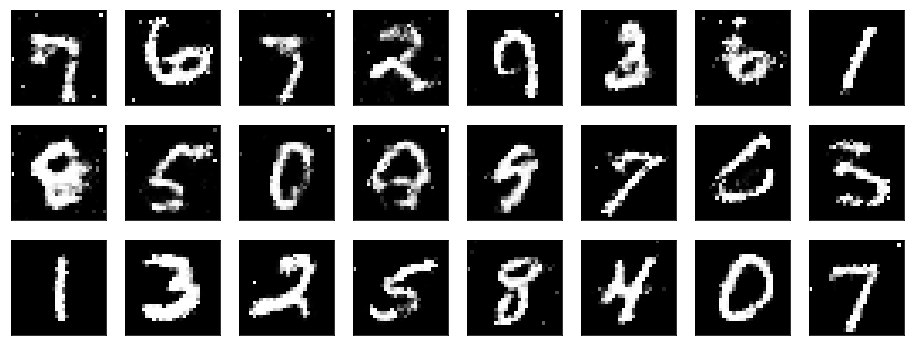

In [10]:
history = model.fit(data_loader, epochs=100)

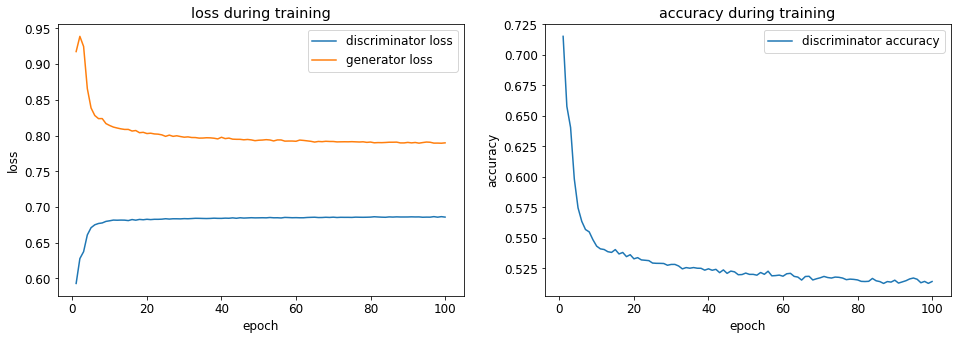

In [11]:
plot_history(history)

In [12]:
class DCGAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.ConvTranspose2d(100, 512, 4),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), x.size(1), 1, 1)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(1, 16, 4, stride=2, padding=1),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(16, 32, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(32),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(32, 64, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(64, 1, 4),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), 1, 28, 28)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), -1)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [13]:
model = DCGAN()

[  1/100] 48.6s - g_loss: 0.8093 - d_loss: 0.6847 - d_acc: 0.5231


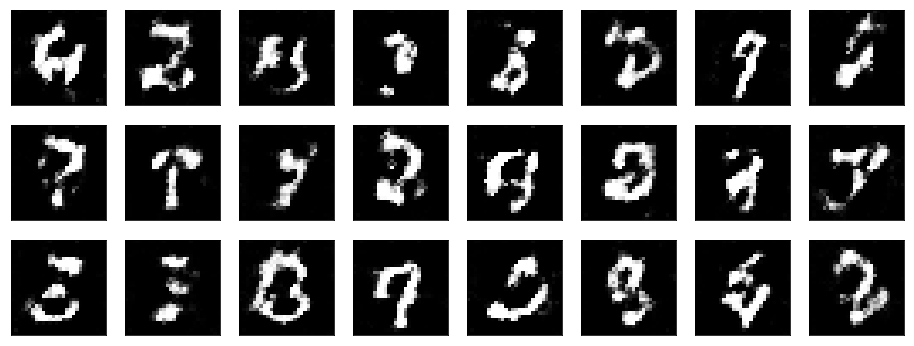

[  2/100] 48.3s - g_loss: 0.7874 - d_loss: 0.6872 - d_acc: 0.5071
[  3/100] 48.0s - g_loss: 0.7846 - d_loss: 0.6882 - d_acc: 0.5024
[  4/100] 48.0s - g_loss: 0.7828 - d_loss: 0.6880 - d_acc: 0.5022
[  5/100] 48.7s - g_loss: 0.7828 - d_loss: 0.6883 - d_acc: 0.5009
[  6/100] 48.7s - g_loss: 0.7821 - d_loss: 0.6886 - d_acc: 0.5006
[  7/100] 48.7s - g_loss: 0.7816 - d_loss: 0.6883 - d_acc: 0.5010
[  8/100] 48.6s - g_loss: 0.7811 - d_loss: 0.6886 - d_acc: 0.4999
[  9/100] 48.8s - g_loss: 0.7801 - d_loss: 0.6886 - d_acc: 0.5003
[ 10/100] 49.2s - g_loss: 0.7802 - d_loss: 0.6883 - d_acc: 0.5003
[ 11/100] 49.3s - g_loss: 0.7799 - d_loss: 0.6883 - d_acc: 0.5000
[ 12/100] 49.3s - g_loss: 0.7811 - d_loss: 0.6885 - d_acc: 0.5001
[ 13/100] 49.4s - g_loss: 0.7803 - d_loss: 0.6884 - d_acc: 0.5000
[ 14/100] 49.6s - g_loss: 0.7792 - d_loss: 0.6885 - d_acc: 0.5000
[ 15/100] 48.0s - g_loss: 0.7791 - d_loss: 0.6883 - d_acc: 0.5000
[ 16/100] 49.2s - g_loss: 0.7798 - d_loss: 0.6886 - d_acc: 0.5000
[ 17/100] 

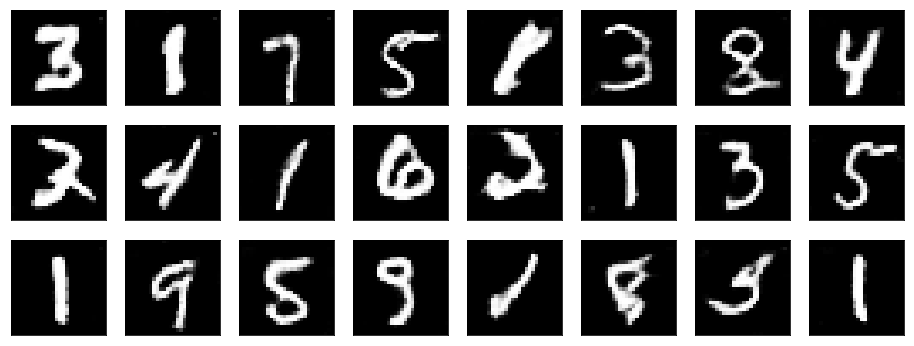

[ 21/100] 48.8s - g_loss: 0.7791 - d_loss: 0.6885 - d_acc: 0.5000
[ 22/100] 48.6s - g_loss: 0.7792 - d_loss: 0.6884 - d_acc: 0.5000
[ 23/100] 48.4s - g_loss: 0.7786 - d_loss: 0.6884 - d_acc: 0.5000
[ 24/100] 48.6s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 25/100] 48.3s - g_loss: 0.7795 - d_loss: 0.6885 - d_acc: 0.5000
[ 26/100] 48.2s - g_loss: 0.7791 - d_loss: 0.6884 - d_acc: 0.5000
[ 27/100] 48.4s - g_loss: 0.7794 - d_loss: 0.6882 - d_acc: 0.5000
[ 28/100] 48.6s - g_loss: 0.7795 - d_loss: 0.6883 - d_acc: 0.5000
[ 29/100] 48.4s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 30/100] 48.3s - g_loss: 0.7796 - d_loss: 0.6883 - d_acc: 0.5000
[ 31/100] 48.0s - g_loss: 0.7790 - d_loss: 0.6883 - d_acc: 0.5000
[ 32/100] 47.9s - g_loss: 0.7788 - d_loss: 0.6883 - d_acc: 0.5000
[ 33/100] 48.6s - g_loss: 0.7792 - d_loss: 0.6882 - d_acc: 0.5000
[ 34/100] 48.3s - g_loss: 0.7786 - d_loss: 0.6884 - d_acc: 0.5000
[ 35/100] 48.1s - g_loss: 0.7789 - d_loss: 0.6883 - d_acc: 0.5000
[ 36/100] 

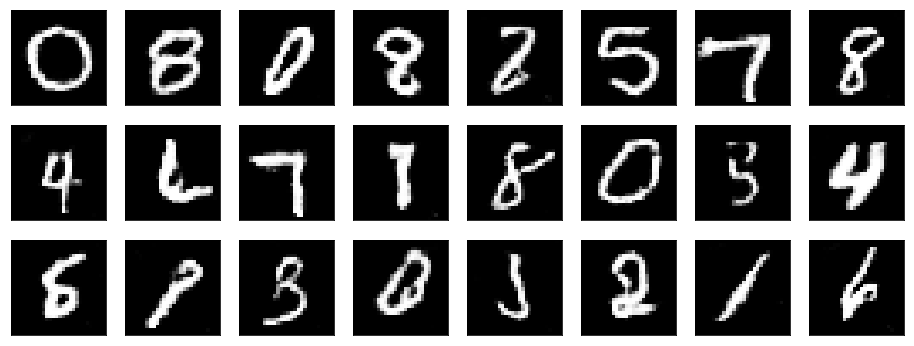

[ 41/100] 51.9s - g_loss: 0.7794 - d_loss: 0.6882 - d_acc: 0.5000
[ 42/100] 50.7s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 43/100] 50.0s - g_loss: 0.7793 - d_loss: 0.6883 - d_acc: 0.5000
[ 44/100] 49.4s - g_loss: 0.7792 - d_loss: 0.6882 - d_acc: 0.5000
[ 45/100] 51.2s - g_loss: 0.7781 - d_loss: 0.6884 - d_acc: 0.5000
[ 46/100] 51.1s - g_loss: 0.7786 - d_loss: 0.6883 - d_acc: 0.5000
[ 47/100] 51.3s - g_loss: 0.7789 - d_loss: 0.6883 - d_acc: 0.5000
[ 48/100] 51.1s - g_loss: 0.7785 - d_loss: 0.6882 - d_acc: 0.5000
[ 49/100] 50.7s - g_loss: 0.7794 - d_loss: 0.6882 - d_acc: 0.5000
[ 50/100] 50.6s - g_loss: 0.7786 - d_loss: 0.6883 - d_acc: 0.5000
[ 51/100] 51.2s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 52/100] 51.9s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 53/100] 51.4s - g_loss: 0.7785 - d_loss: 0.6882 - d_acc: 0.5000
[ 54/100] 50.2s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 55/100] 50.1s - g_loss: 0.7790 - d_loss: 0.6882 - d_acc: 0.5000
[ 56/100] 

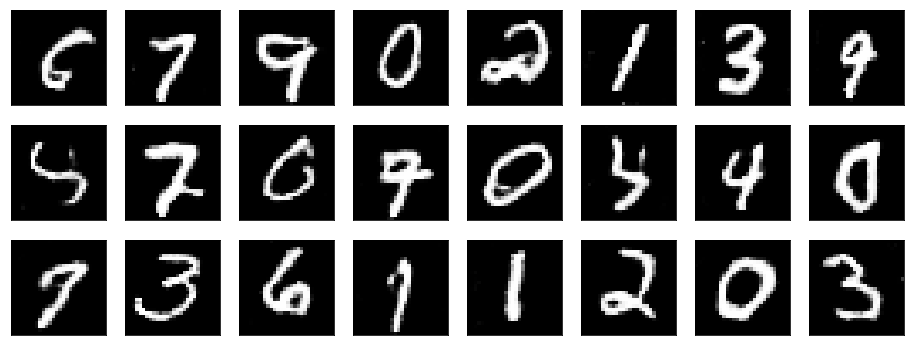

[ 61/100] 50.4s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 62/100] 49.5s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 63/100] 48.3s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 64/100] 48.8s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 65/100] 49.0s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 66/100] 48.4s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 67/100] 48.2s - g_loss: 0.7787 - d_loss: 0.6881 - d_acc: 0.5000
[ 68/100] 48.5s - g_loss: 0.7793 - d_loss: 0.6884 - d_acc: 0.5000
[ 69/100] 48.1s - g_loss: 0.7785 - d_loss: 0.6882 - d_acc: 0.5000
[ 70/100] 48.3s - g_loss: 0.7785 - d_loss: 0.6883 - d_acc: 0.5000
[ 71/100] 48.7s - g_loss: 0.7785 - d_loss: 0.6882 - d_acc: 0.5000
[ 72/100] 48.6s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 73/100] 48.7s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 74/100] 48.6s - g_loss: 0.7784 - d_loss: 0.6881 - d_acc: 0.5000
[ 75/100] 48.7s - g_loss: 0.7788 - d_loss: 0.6883 - d_acc: 0.5000
[ 76/100] 

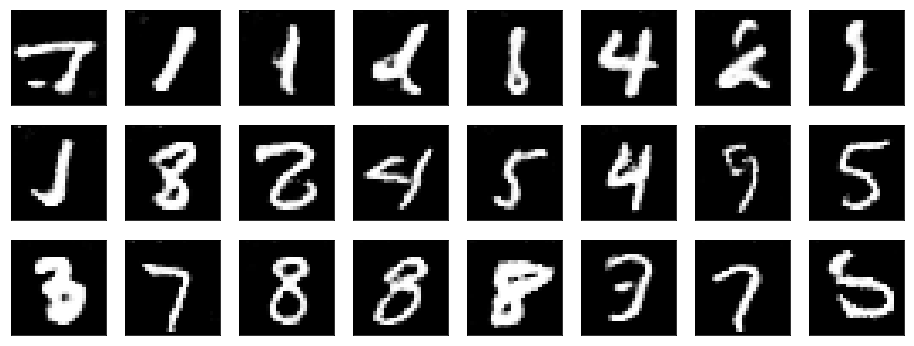

[ 81/100] 48.9s - g_loss: 0.7785 - d_loss: 0.6883 - d_acc: 0.5000
[ 82/100] 49.1s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 83/100] 49.3s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 84/100] 48.7s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 85/100] 48.3s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 86/100] 47.0s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 87/100] 45.8s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 88/100] 45.4s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 89/100] 45.5s - g_loss: 0.7785 - d_loss: 0.6882 - d_acc: 0.5000
[ 90/100] 45.6s - g_loss: 0.7784 - d_loss: 0.6882 - d_acc: 0.5000
[ 91/100] 45.6s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 92/100] 45.6s - g_loss: 0.7786 - d_loss: 0.6881 - d_acc: 0.5000
[ 93/100] 45.5s - g_loss: 0.7780 - d_loss: 0.6882 - d_acc: 0.5000
[ 94/100] 45.6s - g_loss: 0.7782 - d_loss: 0.6882 - d_acc: 0.5000
[ 95/100] 45.6s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 96/100] 

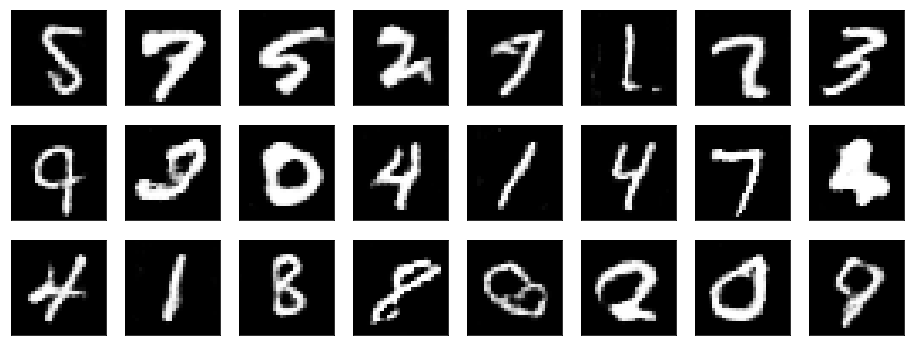

In [14]:
history = model.fit(data_loader, epochs=100)

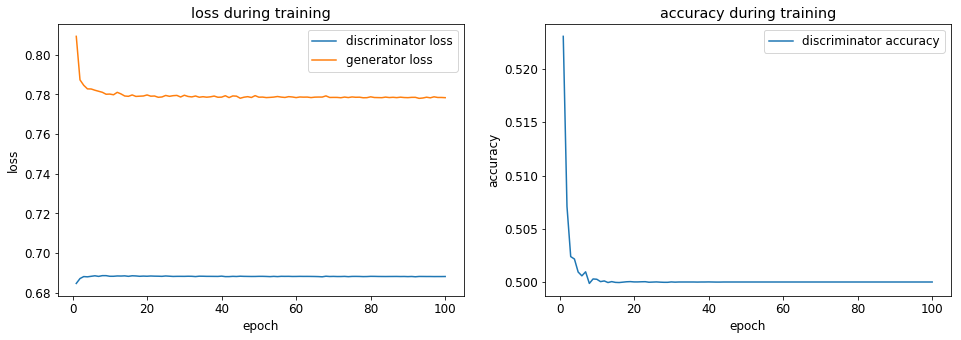

In [15]:
plot_history(history)